In [1]:
!pip install mediapipe opencv-python

DEPRECATION: Loading egg at c:\new folder\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

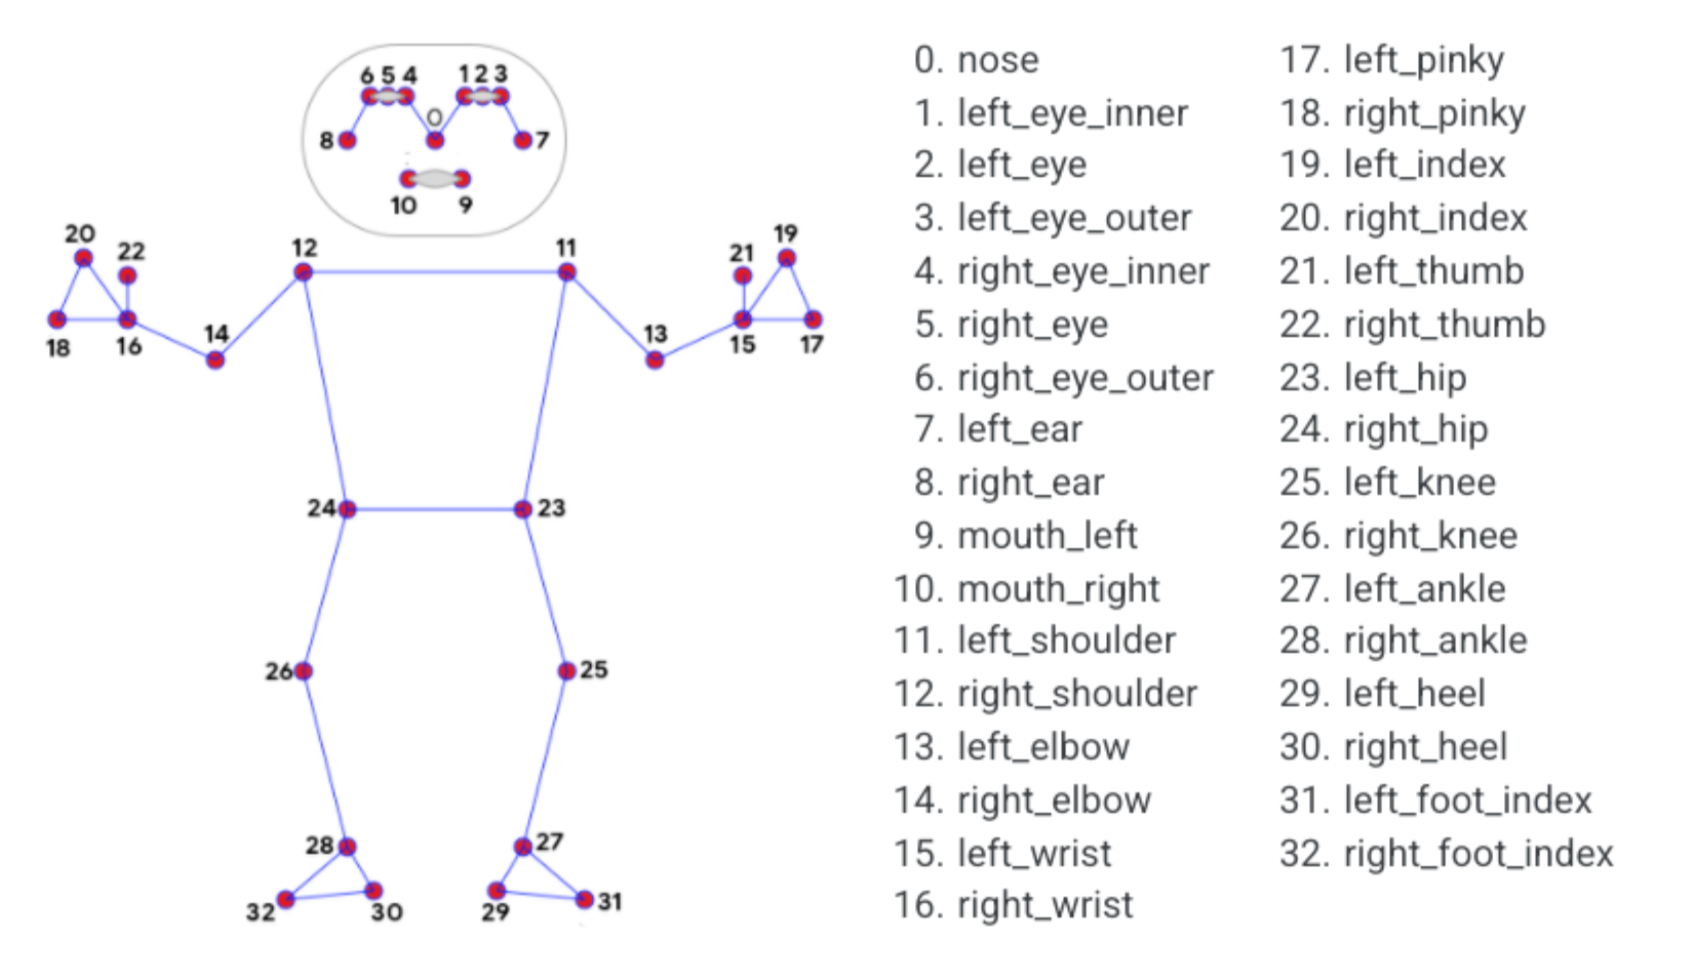

In [ ]:
cap = cv2.VideoCapture(0)

# Curl counter variables
counter = 0 
stage = None

# Setup mediapipe instance
# if we want really accurate model we can tweak these numbers
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read() # reading frame
        
        # Recolor image to RGB
        # This conversion is necessary because the mediapipe library works with RGB images
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False # 'False' to inform mediapipe that it should not modify the input image array
      
        # Make pose detection
        results = pose.process(image)
    
        # Recolor back to BGR
        # In OpenCV, the default color format for images is BGR
        image.flags.writeable = True # 'True'so that the original image array can be modified again
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        try:
            landmarks = results.pose_landmarks.landmark
            # from up above
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            knee= [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]

            # angle calculation same as above
            angle = calculate_angle(shoulder,hip,knee)

            # Visualising angle
            cv2.putText(image, str(angle), 
                           tuple(np.multiply(hip, [640, 480]).astype(int)), # grabbing hip coordinates and multiplying with the dimension of our webcame
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA # font we will/color etc
                                )
            # Curl counter logic
            if angle > 150:        # setting up thershold in case we dont get a perfect 180 degree straight
                stage = "up"
            if angle < 40 and stage =='up': # only if this coming from up position then we go down(we dont want counter to keep spinning up once we pass this angle)
                stage="down"                    # 40 down thershold ensure a rep that doesn't go all the way down is counted
                counter +=1
                print(counter)

        
            
            # print(landmarks)
        except:
            pass

        # Render curl counter
        # Setup status box
        cv2.rectangle(image, (0,0), (225,73), (25,255,255), -1)

        # Rep data
        # Holds the title and counter
        cv2.putText(image, 'SQUAT', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 2, cv2.LINE_AA)

        # Stage data
        #holds the title and stage
        cv2.putText(image, 'STAGE', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (60,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 2, cv2.LINE_AA)
        
        # Render pose landmarks and connections on the frame
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, # using drawing utilities
                                mp_drawing.DrawingSpec(color=(20,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(45,245,245), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image) # rather than showing frame we will display image which actually have all landmarks drwan

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()